# Doc2Vec Model
-------------------------------------

In this example, we will download and preprocess the movie review data.

From this data set we will compute/fit a Doc2Vec model to get document vectors.  From these document vectors, we will split the documents into train/test and use these doc vectors to do sentiment analysis on the movie review dataset.

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


If a temporary data folder does not exist, create it for saving the trained doc2vec embeddings.

In [2]:
# Make a saving directory if it doesn't exist
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

Start a computational graph session.

In [3]:
sess = tf.Session()

Next we declare the model parameters.

In [4]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # Word embedding size
doc_embedding_size = 100   # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # Number of negative examples to sample.
window_size = 3       # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

Now we declare stop words, validation test words, and normalize the review text.

In [5]:
# Declare stop words
#stops = stopwords.words('english')
stops = []

# We pick a few test words for validation.
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]    
assert(len(target)==len(texts))
print('Done.')

Loading Data
Normalizing Text Data
Done.


Next we build our dictionary and transform the text data and validation words accordingly.

In [6]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]
print('Done.')

Creating Dictionary
Done.


We now create our doc2vec model.  There will be two embeddings, a word embedding and a document embedding.

From these two embeddings, we add together the word embeddings and concatenate them to the document embeddings.

In [7]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together element embeddings in window:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

# concatenate embeddings
final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
print('Done.')

Creating Model
Done.


Next we declare our loss function, optimization function, cosine similarity, model saving operations, and initialize the model variables.

In [8]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=final_embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
                                     
# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

Now we can train the doc2vec embedding model.  (This may take a while.  On a desktop computer with TensorFlow running on a CPU, it takes about 20-30 minutes to train the embedding.)

In [9]:
# Run the doc2vec model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 636.482177734375
Loss at step 200 : 598.9559936523438
Loss at step 300 : 609.2671508789062
Loss at step 400 : 592.6265258789062
Loss at step 500 : 540.283203125
Loss at step 600 : 559.7193603515625
Loss at step 700 : 490.82781982421875
Loss at step 800 : 504.45458984375
Loss at step 900 : 519.6517333984375
Loss at step 1000 : 482.2118225097656
Loss at step 1100 : 461.1878662109375
Loss at step 1200 : 501.1067199707031
Loss at step 1300 : 451.1416931152344
Loss at step 1400 : 410.83563232421875
Loss at step 1500 : 419.0462646484375
Loss at step 1600 : 389.7471618652344
Loss at step 1700 : 380.5563049316406
Loss at step 1800 : 387.59930419921875
Loss at step 1900 : 348.9046936035156
Loss at step 2000 : 372.6103820800781
Loss at step 2100 : 300.18878173828125
Loss at step 2200 : 342.6539001464844
Loss at step 2300 : 326.4801330566406
Loss at step 2400 : 360.3497314453125
Loss at step 2500 : 285.4807434082031
Loss at step 2600 : 320.5788269042969
Loss a

Loss at step 17300 : 57.48031997680664
Loss at step 17400 : 63.27518081665039
Loss at step 17500 : 51.63568878173828
Loss at step 17600 : 48.8591423034668
Loss at step 17700 : 61.870723724365234
Loss at step 17800 : 59.94859313964844
Loss at step 17900 : 48.58202362060547
Loss at step 18000 : 49.12833023071289
Loss at step 18100 : 52.154815673828125
Loss at step 18200 : 55.293575286865234
Loss at step 18300 : 52.312984466552734
Loss at step 18400 : 44.60743713378906
Loss at step 18500 : 65.18202209472656
Loss at step 18600 : 50.96884536743164
Loss at step 18700 : 65.36703491210938
Loss at step 18800 : 42.173423767089844
Loss at step 18900 : 55.06301498413086
Loss at step 19000 : 50.34451675415039
Loss at step 19100 : 53.233009338378906
Loss at step 19200 : 54.00133514404297
Loss at step 19300 : 52.54290008544922
Loss at step 19400 : 44.3401985168457
Loss at step 19500 : 51.00914764404297
Loss at step 19600 : 60.216575622558594
Loss at step 19700 : 43.91141128540039
Loss at step 19800 :

Loss at step 34300 : 47.26081466674805
Loss at step 34400 : 30.985103607177734
Loss at step 34500 : 40.996673583984375
Loss at step 34600 : 27.006805419921875
Loss at step 34700 : 40.345664978027344
Loss at step 34800 : 33.933876037597656
Loss at step 34900 : 34.09867858886719
Loss at step 35000 : 37.323856353759766
Nearest to love: to, of, as, at, dean,
Nearest to hate: intensely, graham, maverick, kaufmans, expect,
Nearest to happy: dubbed, burn, they, thomas, weighty,
Nearest to sad: lightweight, applauded, bet, flourishes, dread,
Nearest to man: ritchie, run, best, fastmoving, ultimate,
Nearest to woman: world, grind, suspend, role, poignant,
Model saved in file: /home/jovyan/tensorflow/tensorflow-cookbook/07_Natural_Language_Processing/07_Sentiment_Analysis_With_Doc2Vec/temp/doc2vec_movie_embeddings.ckpt
Loss at step 35100 : 39.70656204223633
Loss at step 35200 : 39.528526306152344
Loss at step 35300 : 28.29694938659668
Loss at step 35400 : 28.814603805541992
Loss at step 35500 : 

Loss at step 50100 : 32.93672561645508
Loss at step 50200 : 27.713502883911133
Loss at step 50300 : 20.549280166625977
Loss at step 50400 : 33.019840240478516
Loss at step 50500 : 23.6355037689209
Loss at step 50600 : 25.67547035217285
Loss at step 50700 : 27.682172775268555
Loss at step 50800 : 20.20789909362793
Loss at step 50900 : 24.9012393951416
Loss at step 51000 : 25.61107063293457
Loss at step 51100 : 28.75664520263672
Loss at step 51200 : 31.020254135131836
Loss at step 51300 : 48.91586685180664
Loss at step 51400 : 30.144535064697266
Loss at step 51500 : 33.94581985473633
Loss at step 51600 : 25.689538955688477
Loss at step 51700 : 29.226165771484375
Loss at step 51800 : 26.647127151489258
Loss at step 51900 : 25.265647888183594
Loss at step 52000 : 22.607757568359375
Loss at step 52100 : 33.02296829223633
Loss at step 52200 : 32.6999397277832
Loss at step 52300 : 21.742530822753906
Loss at step 52400 : 38.730594635009766
Loss at step 52500 : 23.154138565063477
Loss at step 5

Loss at step 67100 : 29.635906219482422
Loss at step 67200 : 22.647464752197266
Loss at step 67300 : 18.287641525268555
Loss at step 67400 : 24.399168014526367
Loss at step 67500 : 25.859975814819336
Loss at step 67600 : 32.58796691894531
Loss at step 67700 : 24.413103103637695
Loss at step 67800 : 16.26563262939453
Loss at step 67900 : 25.008970260620117
Loss at step 68000 : 23.873464584350586
Loss at step 68100 : 22.285863876342773
Loss at step 68200 : 25.629558563232422
Loss at step 68300 : 22.538711547851562
Loss at step 68400 : 16.118459701538086
Loss at step 68500 : 22.88547134399414
Loss at step 68600 : 21.581995010375977
Loss at step 68700 : 28.71849822998047
Loss at step 68800 : 21.201704025268555
Loss at step 68900 : 20.771059036254883
Loss at step 69000 : 21.20854377746582
Loss at step 69100 : 22.763874053955078
Loss at step 69200 : 23.66249656677246
Loss at step 69300 : 23.650390625
Loss at step 69400 : 24.109874725341797
Loss at step 69500 : 27.464521408081055
Loss at step

Loss at step 84100 : 17.72014808654785
Loss at step 84200 : 18.975078582763672
Loss at step 84300 : 18.228960037231445
Loss at step 84400 : 17.054718017578125
Loss at step 84500 : 15.666707038879395
Loss at step 84600 : 30.684953689575195
Loss at step 84700 : 17.66436767578125
Loss at step 84800 : 19.471513748168945
Loss at step 84900 : 31.52216148376465
Loss at step 85000 : 23.606544494628906
Nearest to love: to, as, of, at, in,
Nearest to hate: intensely, graham, maverick, expect, kaufmans,
Nearest to happy: dubbed, they, burn, thomas, plenty,
Nearest to sad: lightweight, applauded, flourishes, dread, bet,
Nearest to man: best, his, ritchie, like, for,
Nearest to woman: world, grind, suspend, poignant, role,
Model saved in file: /home/jovyan/tensorflow/tensorflow-cookbook/07_Natural_Language_Processing/07_Sentiment_Analysis_With_Doc2Vec/temp/doc2vec_movie_embeddings.ckpt
Loss at step 85100 : 26.990554809570312
Loss at step 85200 : 24.378175735473633
Loss at step 85300 : 25.6769523620

## Now we can use the above embeddings to train a logistic model to predict sentiment.
---------------------------

Here are some parameters of the logistic model:

In [10]:
max_words = 20
logistic_batch_size = 500

Split dataset into train and test sets.

In [11]:
# Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

Now we define our logistic model.  First the placeholders, then the embeddings (word and document embeddings from above training), and then our logistic regression operations.

In [12]:
# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# concatenate embeddings
log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)

Loss function, Prediction function, Optimization function and variable initializer.

In [13]:
# Declare loss function (Cross Entropy loss)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

Now we start our logistic regression training for sentiment.

In [14]:
# Start Logistic Regression
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # Append review index at the end of text data
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 6.58 (7.11). Train Acc (Test Acc): 0.57 (0.55)
Generation # 1000. Train Loss (Test Loss): 4.46 (5.35). Train Acc (Test Acc): 0.58 (0.52)
Generation # 1500. Train Loss (Test Loss): 3.33 (3.90). Train Acc (Test Acc): 0.58 (0.57)
Generation # 2000. Train Loss (Test Loss): 2.36 (2.59). Train Acc (Test Acc): 0.59 (0.60)
Generation # 2500. Train Loss (Test Loss): 2.32 (2.63). Train Acc (Test Acc): 0.59 (0.54)
Generation # 3000. Train Loss (Test Loss): 2.09 (1.99). Train Acc (Test Acc): 0.56 (0.59)
Generation # 3500. Train Loss (Test Loss): 2.51 (2.96). Train Acc (Test Acc): 0.58 (0.52)
Generation # 4000. Train Loss (Test Loss): 1.99 (1.83). Train Acc (Test Acc): 0.56 (0.56)
Generation # 4500. Train Loss (Test Loss): 2.45 (2.44). Train Acc (Test Acc): 0.57 (0.53)
Generation # 5000. Train Loss (Test Loss): 1.79 (1.75). Train Acc (Test Acc): 0.57 (0.59)
Generation # 5500. Train Loss (Test Loss): 1.69 (1.81). Trai

Here is matplotlib code for plotting the train/test loss and accuracy.

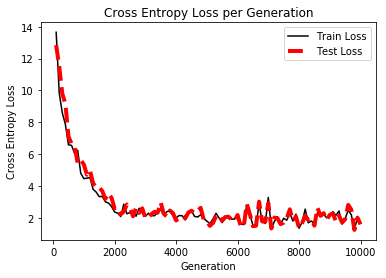

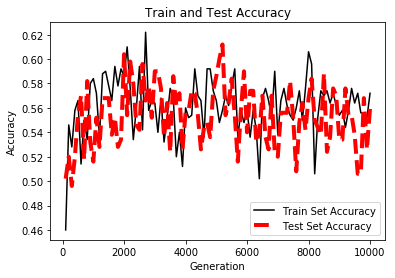

In [15]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

To make improvements, we should focus on improving the doc2vec embeddings.  Potential doc2vec improvements may come with stemming of words, expanding stop words, and more training.

And for improving the logistic regression, we could add a hidden layer and also increase batch size and exponentially reduce the learning rate.

In [ ]:
test complete; Gopal